In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import re


In [3]:
# Configuración general
plt.style.use('dark_background')  # Fondo oscuro

# Color de fondo personalizado (hex, RGB o nombre)
sns.set_palette("pastel")         # Paleta pastel (Seaborn)
colores_pastel = ['#A65B62', "#FFB3BA", "#FFDFBA", "#BAFFC9", "#BAE1FF", "#D0BAFF", "#F9B7FF"]
sns.set_palette(colores_pastel)

In [4]:
data = pd.read_csv('hltb_data.csv')
data

C:\Users\conid\AppData\Local\Temp\ipykernel_32284\746695557.py:1: DtypeWarning: Columns (12,14,16,17,18,19,20,24,25,26,27,28,29,30,31,88) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('hltb_data.csv')


,game_count_discussion,game_game_id,game_game_name,game_game_name_date,game_count_playing,game_count_backlog,game_count_replay,game_count_custom,game_count_comp,game_count_retired,...,review_60,review_65,review_70,review_75,review_80,review_85,review_90,review_95,review_100,review_review_count
0,0,1,688(I) Hunter/Killer,0,1,82,2,3,11,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,2,Beyond Good & Evil 2,0,0,80,0,3,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0,18,'Splosion Man,0,1,302,14,17,179,43,...,13.0,1.0,20.0,NaN,21.0,1.0,14.0,NaN,4.0,79
3,0,19,.hack//G.U. Vol. 1: Rebirth,0,0,316,11,14,274,18,...,9.0,NaN,34.0,1.0,34.0,1.0,13.0,NaN,9.0,110
4,0,20,.hack//G.U. Vol. 2: Reminisce,0,0,291,5,14,165,8,...,7.0,NaN,17.0,NaN,27.0,1.0,9.0,NaN,6.0,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147469,0,164069,taptube,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
147470,0,164070,the homelles,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
147471,0,164071,tuber more or less,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
147472,0,164072,upgrade the game,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
total_games = data['game_game_id'].nunique()
total_games

147474

In [6]:
count_esrb = data['game_rating_esrb'].value_counts()
print('Hay {} juegos con rating ESRB'.format(count_esrb.sum()))

count_pegi = data['game_rating_pegi'].value_counts()
print('Hay {} juegos con rating PEGI'.format(count_pegi.sum()))

count_cero = data['game_rating_cero'].value_counts()
print('Hay {} juegos con rating CERO'.format(count_cero.sum()))

print('En total hay {} juegos con rating'.format(count_esrb.sum() + count_pegi.sum() + count_cero.sum()))

Hay 7160 juegos con rating ESRB
Hay 3631 juegos con rating PEGI
Hay 1872 juegos con rating CERO
En total hay 12663 juegos con rating


In [7]:
count_esrb = data['game_comp_lvl_platform'].value_counts()
count_esrb

game_comp_lvl_platform
0    147287
1       187
Name: count, dtype: int64

1.  Limpiar dataset 
2. Pregunta: ¿Existen combinaciones de géneros o características (ej: "RPG + Open World") que correlacionen con tasas de abandono excepcionalmente altas/bajas?

--> Transformacion a valores numericos generos 

--> Resumen de ajustes recomendados
Preprocesamiento:

Usar MultiLabelBinarizer para géneros.

Normalizar/normalizar features.

Modelado:

Empezar con K-Means++ y DBSCAN/OPTICS.

Reducir dimensionalidad si hay muchas features.

Evaluación:

Silhouette Score + análisis descriptivo/visual.

Alternativas:

Considerar enfoques supervisados o reglas de asociación. 


Veremos cómo es la cantidad de géneros presentes en el Data Frame

In [29]:
# Limpiamos el DataFrame, seleccionando columnas relevantes

data_clean = data[['game_game_name', 'game_game_id', 'game_count_playing', 'game_count_replay', 'game_count_comp', 'game_count_retired', 'game_count_total' , 'game_game_type', 'game_profile_platform', 'game_profile_genre', 'game_rating_esrb', 'game_comp_lvl_sp', 'game_comp_lvl_co', 'game_comp_lvl_mp']]


## Genres

In [10]:
genres = data_clean['game_profile_genre']
genres

0                   Simulation
1            Action, Adventure
2                       Action
3         Action, Role-Playing
4         Action, Role-Playing
                  ...         
147469                     NaN
147470                     NaN
147471                     NaN
147472                     NaN
147473                     NaN
Name: game_profile_genre, Length: 147474, dtype: object

Notamos que hay ciertos géneros que se parecen, por lo cual hay que mirar con mayor detalle cómo es la distribución de estos.

In [11]:
import pandas as pd
from difflib import get_close_matches

# Paso 1: Normalización básica
def normalize_genre(genre):
    return genre.strip().lower()

genres = data_clean['game_profile_genre']
all_genres = []

for game in genres:
    if pd.isna(game):  # verificamos que el género no sea NaN
        continue
    for genre in game.split(','):
        normalized = normalize_genre(genre)
        if normalized not in all_genres:
            all_genres.append(normalized)

# Paso 2: Encontrar géneros similares
threshold = 0.7  # Ajusta este valor para mayor/menor sensibilidad
similar_genres = {}

for genre in all_genres:
    # Encuentra géneros similares (usando difflib)
    matches = get_close_matches(genre, all_genres, n=10, cutoff=threshold)
    matches = [m for m in matches if m != genre]
    
    if matches:
        similar_genres[genre] = matches

# Paso 3: Crear DataFrame para revisión manual
similar_df = pd.DataFrame.from_dict(similar_genres, orient='index')
similar_df = similar_df.reset_index()
similar_df.to_csv('generos_similares.csv', index=False)
similar_df.columns = ['Género Original', 'Similitud 1', 'Similitud 2', 'Similitud 3', 'Similitud 4', 'Similitud 5', 'Similitud 6', 'Similitud 7', 'Similitud 8', 'Similitud 9']

print(f"Total de géneros únicos iniciales: {len(all_genres)}")
print(f"Se encontraron {len(similar_genres)} géneros con posibles similitudes")
similar_df

Total de géneros únicos iniciales: 247
Se encontraron 159 géneros con posibles similitudes


,Género Original,Similitud 1,Similitud 2,Similitud 3,Similitud 4,Similitud 5,Similitud 6,Similitud 7,Similitud 8,Similitud 9
0,simulation,farm simulation,date simulation,space simulation,mecha simulation,flight simulation,combat simulation,vehicle simulation,medical simulation,None
1,action,action rpg,None,None,None,None,None,None,None,None
2,adventure,adventure.,action-adventure,action adventure,None,None,None,None,None,None
3,role-playing,role playing,role-playing game,action role-playing,console role-playing,tactical role-playing,computer role-playing,None,None,None
4,action rpg,action driving,action,tactical rpg,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
154,medical simulation,mecha simulation,vehicle simulation,date simulation,mech simulator,combat simulation,farm simulation,simulation,space simulation,None
155,first-person adventure,third-person action-adventure,third-person action adventure,first-person shooter,first-person,None,None,None,None,None
156,twin stick shooter,tactical shooter,None,None,None,None,None,None,None,None
157,console rpg,console role-playing,None,None,None,None,None,None,None,None


In [12]:
# Notamos que hay filas que son permutaciones de otras, por lo que las eliminamos

# Función para crear fila única
def crear_fila_unica(row):
    # Obtener valores no vacíos, ordenarlos y unirlos como string
    valores = [str(x) for x in row if pd.notna(x) and str(x).strip() != '']
    return '|'.join(sorted(valores))

# Aplicar a cada fila
similar_df['firma'] = similar_df.apply(crear_fila_unica, axis=1)

# Mantener solo la primera aparición de cada firma
df_unico = similar_df.drop_duplicates(subset='firma', keep='first')

# Eliminar la columna temporal de firma
df_unico = df_unico.drop(columns=['firma'])

# Guardar el resultado
df_unico.to_csv('genres_unico.csv')
df_unico

,Género Original,Similitud 1,Similitud 2,Similitud 3,Similitud 4,Similitud 5,Similitud 6,Similitud 7,Similitud 8,Similitud 9
0,simulation,farm simulation,date simulation,space simulation,mecha simulation,flight simulation,combat simulation,vehicle simulation,medical simulation,None
1,action,action rpg,None,None,None,None,None,None,None,None
2,adventure,adventure.,action-adventure,action adventure,None,None,None,None,None,None
3,role-playing,role playing,role-playing game,action role-playing,console role-playing,tactical role-playing,computer role-playing,None,None,None
4,action rpg,action driving,action,tactical rpg,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
153,aerial combat,car combat,vehicle combat,space combat,None,None,None,None,None,None
154,medical simulation,mecha simulation,vehicle simulation,date simulation,mech simulator,combat simulation,farm simulation,simulation,space simulation,None
155,first-person adventure,third-person action-adventure,third-person action adventure,first-person shooter,first-person,None,None,None,None,None
156,twin stick shooter,tactical shooter,None,None,None,None,None,None,None,None


Nos encontramos con 3 principales problemas para los géneros:

1. Hay géneros que en si son lo mismo pero escritos de distinta forma: 'role-playing,role playing,role-playing game, ... '.

2. Hay géneros que están compuesto por otros: 'action role-playing' --> 'action' y 'role-playing', 'platform/puzzle' --> 'platform' y 'puzzle'.

3. Combinaciones de las dos anteriores: 'multidirectional shooter,multi-directional shooter,multidirectional' --> se puede separar 'multidirectional' y 'shooter' y también está la forma de escribir 'multidirectional' o 'multi-directional'.

Entonces se necesita, primero nombrar a todos los géneros principales de la misma forma para no estar clasificándolos como distinto y luego separar los géneros que se encuentren compuestos por dos o más géneros principales.

In [13]:
# Creamos una lista para almacenar los géneros únicos
genres_list = []

for game in genres:
    if pd.isna(game):  # verificamos que el género no sea NaN
        continue
    for genre in game.split(','):
        normalized = normalize_genre(genre)
        if normalized not in genres_list: # revisamos si el género ya está en la lista
            genres_list.append(normalized) # si no está, lo agregamos 
            
            print('Género agregado: {}'.format(normalized))
            print('Hay {} géneros únicos'.format(len(genres_list)))

# Eliminamos los juegos que no tienen genero
print()
print('Hay {} juegos sin género'.format(data_clean['game_profile_genre'].isna().sum()))
print('Hay {} juegos con género'.format(data_clean['game_profile_genre'].notna().sum()))


Género agregado: simulation
Hay 1 géneros únicos
Género agregado: action
Hay 2 géneros únicos
Género agregado: adventure
Hay 3 géneros únicos
Género agregado: role-playing
Hay 4 géneros únicos
Género agregado: action rpg
Hay 5 géneros únicos
Género agregado: first-person
Hay 6 géneros únicos
Género agregado: shooter
Hay 7 géneros únicos
Género agregado: racing/driving
Hay 8 géneros únicos
Género agregado: top-down
Hay 9 géneros únicos
Género agregado: puzzle
Hay 10 géneros únicos
Género agregado: music
Hay 11 géneros únicos
Género agregado: platform
Hay 12 géneros únicos
Género agregado: sports
Hay 13 géneros únicos
Género agregado: card game
Hay 14 géneros únicos
Género agregado: roguelike
Hay 15 géneros únicos
Género agregado: various
Hay 16 géneros únicos
Género agregado: arcade
Hay 17 géneros únicos
Género agregado: visual novel
Hay 18 géneros únicos
Género agregado: scrolling
Hay 19 géneros únicos
Género agregado: vertical scrolling shooter
Hay 20 géneros únicos
Género agregado: t

In [14]:
# Carga el archivo (ajusta el nombre si es otro)
df = pd.read_excel('genres_map.xlsx', header=None)  # o .csv si es CSV

# Crear diccionario
genre_map = defaultdict(list)

for row in df.itertuples(index=False):
    # Convertimos a lista de strings (ignorando NaN)
    fila = [str(x).strip().lower() for x in row if pd.notnull(x)]
    if not fila:
        continue
    canon = fila[0]
    variantes = fila[1:]
    genre_map[canon].extend(variantes)

replacement_dict = {}
for canon, variants in genre_map.items():
    for v in variants:
        replacement_dict[v] = canon
    replacement_dict[canon] = canon  # el propio canon también
    
def split_genres(raw_str):
    # Divide por coma o slash y limpia espacios
    #print('Dividiendo géneros:', raw_str)
    if not isinstance(raw_str, str):
        return []  # si no es string, devolvemos lista vacía
    parts = re.split(r'[,/]', raw_str.lower())
    return [p.strip() for p in parts if p.strip()]

def normalize_genres(genre_list, replacement_dict):
    normalized = []
    for g in genre_list:
        if g in replacement_dict:
            canon = replacement_dict[g]
            # separar si es compuesto como 'action role-playing'
            for part in canon.split():
                if part not in normalized:
                    normalized.append(part)
        else:
            # si no está en el diccionario, lo dejamos tal cual o intentamos descomponer
            for part in g.split():
                if part not in normalized:
                    normalized.append(part)
    return normalized


En lo siguiente comparemos la columna de géneros inicial con la obtenida después del filtrado y normalizado de los géneros.

In [15]:
data_clean.dropna(subset=['game_profile_genre'], inplace=True)  # Eliminamos filas sin género
data_clean.sample(15, random_state=42)['game_profile_genre']  # Muestra aleatoria de 15 juegos

C:\Users\conid\AppData\Local\Temp\ipykernel_32284\2776148033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.dropna(subset=['game_profile_genre'], inplace=True)  # Eliminamos filas sin género


47460                                       Virtual Reality
94046                         Management, Strategy/Tactical
26077                                            Simulation
84878                          Real-Time, Strategy/Tactical
31246                Virtual Reality, Adventure, Simulation
19193                                                Action
76985                                            Simulation
24096                                      Arcade, Platform
138246                                            Adventure
27230                                                Puzzle
72953                                            Simulation
125686                                 Action, Role-Playing
43284                            Virtual Reality, Adventure
86488     Third-Person, Adventure, Role-Playing, Simulation
51262                Massively Multiplayer, Arcade, Shooter
Name: game_profile_genre, dtype: object

In [16]:
dt_cop = data_clean.copy() # creamos una copia para trabajar
dt_cop['normalized_genres'] = dt_cop['game_profile_genre'].apply(lambda x: normalize_genres(split_genres(x), replacement_dict)) # eliminamos la columna original
dt_cop.dropna(subset=['game_profile_genre'], inplace=True)
dt_cop.sample(15, random_state=42)['normalized_genres']

47460                                    [virtual, reality]
94046                      [management, strategy, tactical]
26077                                          [simulation]
84878                       [real-time, strategy, tactical]
31246             [virtual, reality, adventure, simulation]
19193                                              [action]
76985                                          [simulation]
24096                                    [arcade, platform]
138246                                          [adventure]
27230                                              [puzzle]
72953                                          [simulation]
125686                               [action, role-playing]
43284                         [virtual, reality, adventure]
86488     [third-person, adventure, role-playing, simula...
51262             [massively, multiplayer, arcade, shooter]
Name: normalized_genres, dtype: object

In [17]:
# Usamos una lista para juntar todos los géneros de todos los juegos
all_genres = dt_cop['normalized_genres'].explode()

# Sacamos los únicos
unique_genres = all_genres.dropna().unique().tolist()
print("Géneros únicos encontrados:", unique_genres)

# Otra vez usamos explode para tener un género por fila
genre_counts = dt_cop['normalized_genres'].explode().value_counts()
print("Conteo por género:")
print(genre_counts)


Géneros únicos encontrados: ['simulation', 'action', 'adventure', 'role-playing', 'rpg', 'first-person', 'shooter', 'racing', 'driving', 'top-down', 'puzzle', 'music', 'platform', 'sports', 'card', 'game', 'roguelike', 'various', 'arcade', 'visual', 'novel', 'scrolling', 'vertical', 'third-person', 'on-rails', 'open', 'world', 'pinball', 'side', 'point-and-click', 'text', 'real-time', 'strategy', 'city-building', 'shoot-em-up', 'combat', 'flight', 'simulator', 'vehicular', 'sandbox', 'trivia', 'compilation', 'fighting', 'turn-based', 'tactical', 'survival', 'horror', 'massively', 'multiplayer', 'educational', 'historical', 'hack-and-slash', 'isometric', '3d', 'beat-em-up', 'stealth', 'hidden', 'object', 'rhythm', 'life', 'tower', 'defense', 'party', 'virtual', 'reality', 'multidirectional', 'light-gun', 'breakout', 'mecha', 'art', 'side-scroller', 'battle', 'arena', 'graphic', 'incremental', 'board', 'space', 'trading', 'tactics', 'casual', 'indie', 'interactive', 'american-football', 

In [18]:
# Veamos que generos tienen solo un juego
single_game_genres = genre_counts[genre_counts == 1].index.tolist()
print("Géneros con un solo juego:", single_game_genres)
print("Total de géneros con un solo juego:", len(single_game_genres))

Géneros con un solo juego: ['american-football', 'life', 'trading', 'pub', '4x', 'god', 'farm', 'kickboxing', 'medieval', 'weapon-based', 'flying', 'computer', 'ad', 'fps', 'platforming', 'prinnies.com', 'sci-fi', 'business', 'edutainment', 'submarine', 'date', 'fishing', 'anazign', 'fiction', 'www.cobramobile.com', 'twin', 'medical', 'stick', 'western', 'steampunk', 'brawler']
Total de géneros con un solo juego: 31


In [19]:
min_count = 5
genres_to_keep = genre_counts[genre_counts >= min_count].index.tolist()
print(f"Total de géneros con al menos {min_count} juegos: {len(genres_to_keep)}")

Total de géneros con al menos 5 juegos: 88


In [20]:
def remove_rare_genres(genre_list, valid_genres):
    if not genre_list:
        return []
    filtered = [g for g in genre_list if g in valid_genres]

    return filtered if filtered else ['NaN']  # evitamos que quede vacío

def remove_irrelevant_genres(genre_list, to_remove):
    return [g for g in genre_list if g not in to_remove]

irrelevant_genres = ['game']

dt_cop['filtered_genres'] = dt_cop['normalized_genres'].apply(lambda x: remove_rare_genres(x, genres_to_keep))
dt_cop['filtered_genres'] = dt_cop['filtered_genres'].apply(lambda x: remove_irrelevant_genres(x, irrelevant_genres))

dt_cop

,game_game_name,game_game_id,game_count_playing,game_count_replay,game_count_replay,game_count_comp,game_count_retired,game_game_type,game_profile_platform,game_profile_genre,game_rating_esrb,game_comp_lvl_sp,game_comp_lvl_co,game_comp_lvl_mp,game_count_retired,game_count_total,normalized_genres,filtered_genres
0,688(I) Hunter/Killer,1,1,2,2,11,16,game,PC,Simulation,E,1,1,1,16,133,[simulation],[simulation]
1,Beyond Good & Evil 2,2,0,0,0,0,1,game,NaN,"Action, Adventure",NaN,1,0,0,1,149,"[action, adventure]","[action, adventure]"
2,'Splosion Man,18,1,14,14,179,43,game,Xbox 360,Action,E10+,1,1,1,43,570,[action],[action]
3,.hack//G.U. Vol. 1: Rebirth,19,0,11,11,274,18,game,"Nintendo Switch, PC, PlayStation 2, PlayStation 4","Action, Role-Playing",T,1,1,1,18,673,"[action, role-playing]","[action, role-playing]"
4,.hack//G.U. Vol. 2: Reminisce,20,0,5,5,165,8,game,"Nintendo Switch, PC, PlayStation 2, PlayStation 4","Action, Role-Playing",T,1,1,1,8,526,"[action, role-playing]","[action, role-playing]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147273,Legend of Nara,163873,0,0,0,1,0,game,Browser,"Third-Person, Action, Arcade, Battle Arena",NaN,1,0,0,0,2,"[third-person, action, arcade, battle, arena]","[third-person, action, arcade, battle, arena]"
147280,Mobile Suit Gundam SEED: Battle Destiny Remast...,163880,0,0,0,0,0,game,"Nintendo Switch, PC",Action,NaN,1,0,0,0,2,[action],[action]
147281,FUBUKI ~zero in on Holoearth~ HOLOLIVE ALTERNA...,163881,0,0,0,0,0,game,PC,"Side, Scrolling, Action",NaN,1,0,0,0,2,"[side, scrolling, action]","[side, scrolling, action]"
147282,Calamity Angels: Special Delivery,163882,0,0,0,0,0,game,"Nintendo Switch, PC, PlayStation 4, PlayStation 5",Role-Playing,NaN,1,1,1,0,1,[role-playing],[role-playing]


In [21]:
# Veamos las filas que quedaron como 'NaN' en el filtered_genres
na_rows = dt_cop[dt_cop['filtered_genres'].apply(lambda x: 'NaN' in x)]

# Ahora contamos cuántas filas son
na_count = na_rows.shape[0]
print(f"Total de filas con géneros filtrados como 'NaN': {na_count}")

# Eliminamos las filas que tienen 'NaN' en filtered_genres
dt_cop = dt_cop[~dt_cop['filtered_genres'].apply(lambda x: 'NaN' in x)]
dt_cop

Total de filas con géneros filtrados como 'NaN': 20


,game_game_name,game_game_id,game_count_playing,game_count_replay,game_count_replay,game_count_comp,game_count_retired,game_game_type,game_profile_platform,game_profile_genre,game_rating_esrb,game_comp_lvl_sp,game_comp_lvl_co,game_comp_lvl_mp,game_count_retired,game_count_total,normalized_genres,filtered_genres
0,688(I) Hunter/Killer,1,1,2,2,11,16,game,PC,Simulation,E,1,1,1,16,133,[simulation],[simulation]
1,Beyond Good & Evil 2,2,0,0,0,0,1,game,NaN,"Action, Adventure",NaN,1,0,0,1,149,"[action, adventure]","[action, adventure]"
2,'Splosion Man,18,1,14,14,179,43,game,Xbox 360,Action,E10+,1,1,1,43,570,[action],[action]
3,.hack//G.U. Vol. 1: Rebirth,19,0,11,11,274,18,game,"Nintendo Switch, PC, PlayStation 2, PlayStation 4","Action, Role-Playing",T,1,1,1,18,673,"[action, role-playing]","[action, role-playing]"
4,.hack//G.U. Vol. 2: Reminisce,20,0,5,5,165,8,game,"Nintendo Switch, PC, PlayStation 2, PlayStation 4","Action, Role-Playing",T,1,1,1,8,526,"[action, role-playing]","[action, role-playing]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147273,Legend of Nara,163873,0,0,0,1,0,game,Browser,"Third-Person, Action, Arcade, Battle Arena",NaN,1,0,0,0,2,"[third-person, action, arcade, battle, arena]","[third-person, action, arcade, battle, arena]"
147280,Mobile Suit Gundam SEED: Battle Destiny Remast...,163880,0,0,0,0,0,game,"Nintendo Switch, PC",Action,NaN,1,0,0,0,2,[action],[action]
147281,FUBUKI ~zero in on Holoearth~ HOLOLIVE ALTERNA...,163881,0,0,0,0,0,game,PC,"Side, Scrolling, Action",NaN,1,0,0,0,2,"[side, scrolling, action]","[side, scrolling, action]"
147282,Calamity Angels: Special Delivery,163882,0,0,0,0,0,game,"Nintendo Switch, PC, PlayStation 4, PlayStation 5",Role-Playing,NaN,1,1,1,0,1,[role-playing],[role-playing]


C:\Users\conid\AppData\Local\Temp\ipykernel_32284\277756356.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette="twilight", edgecolor='w', linewidth=1.5,  zorder=2, alpha = 0.6)


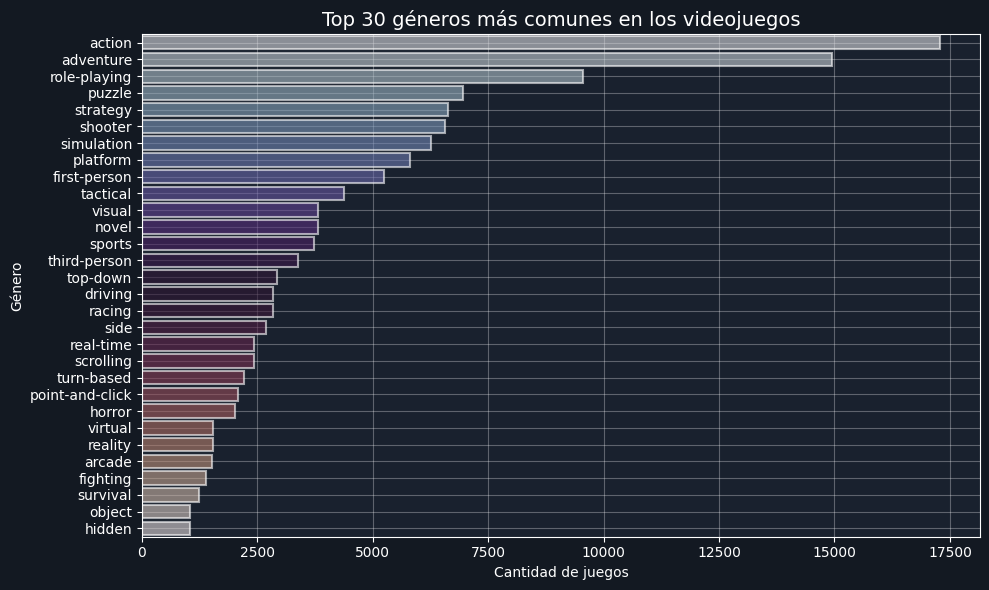

In [22]:
# Hacemos grafico de barras con los géneros filtrados
genres_count = dt_cop['filtered_genres'].explode().value_counts()
top_n = 30
top_genres = genres_count.head(top_n)

# Estilo más lindo
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette="twilight", edgecolor='w', linewidth=1.5,  zorder=2, alpha = 0.6)
fig.patch.set_facecolor("#131922")  # Fondo de la figura (exterior)
ax.set_facecolor("#19212E")         # Fondo del área del gráfico (interior)
plt.grid(zorder=1, alpha=0.3)
plt.title(f"Top {top_n} géneros más comunes en los videojuegos", fontsize=14)
plt.xlabel("Cantidad de juegos")
plt.ylabel("Género")
plt.tight_layout()
plt.show()

## Rating

In [23]:
# Vemos la cantidad de juegos con y sin rating 
print('Hay {} juegos con rating'.format(data_clean['game_rating_esrb'].notna().sum()))
print('Hay {} juegos sin rating'.format(data_clean['game_rating_esrb'].isna().sum()))
print('Corresponde a un {}% de los juegos'.format(round(data_clean['game_rating_esrb'].notna().sum() / len(data_clean) * 100, 2)))

Hay 6906 juegos con rating
Hay 66112 juegos sin rating
Corresponde a un 9.46% de los juegos


El rating no parece un buen dato a ocupar debido a la cantidad de juegos que se eliminan, pues se estaría ocupando solo menos de un 10% de la muestra que se tiene. Entonces, para el análisis se descarte el uso de la variable rating.

In [24]:
# Vemos la cantidad de juegos con y sin plataforma
print('Hay {} juegos con plataforma'.format(data_clean['game_profile_platform'].notna().sum()))
print('Hay {} juegos sin plataforma'.format(data_clean['game_profile_platform'].isna().sum()))
print('Corresponde a un {}% de los juegos'.format(round(data_clean['game_profile_platform'].notna().sum() / len(data_clean) * 100, 2)))

Hay 70116 juegos con plataforma
Hay 2902 juegos sin plataforma
Corresponde a un 96.03% de los juegos


## Platforms

In [25]:
# Contamos las plataformas únicas
platforms = data_clean['game_profile_platform'].unique()
print('Hay {} plataformas únicas'.format(len(platforms)))
platforms

Hay 3574 plataformas únicas


array(['PC', nan, 'Xbox 360', ..., 'Linux, Mac',
       'NEC PC-88, NEC PC-98, NES, Sharp X1',
       'Arcade, Nintendo Switch, PC, PlayStation 4, PlayStation 5'],
      dtype=object)

## Types

In [26]:
# Vemos el tipo de juego 
print(data_clean['game_game_type'].value_counts())

# Revisamos si alguno es NaN
print('Hay {} juegos sin tipo'.format(data_clean['game_game_type'].isna().sum()))

game_game_type
game       66253
dlc         2226
multi       1816
sports       628
compil       590
endless      367
mod          331
hack         260
omit         182
delay         64
Name: count, dtype: int64
Hay 301 juegos sin tipo


Text(0.5, 1.0, 'Tipos de juegos')

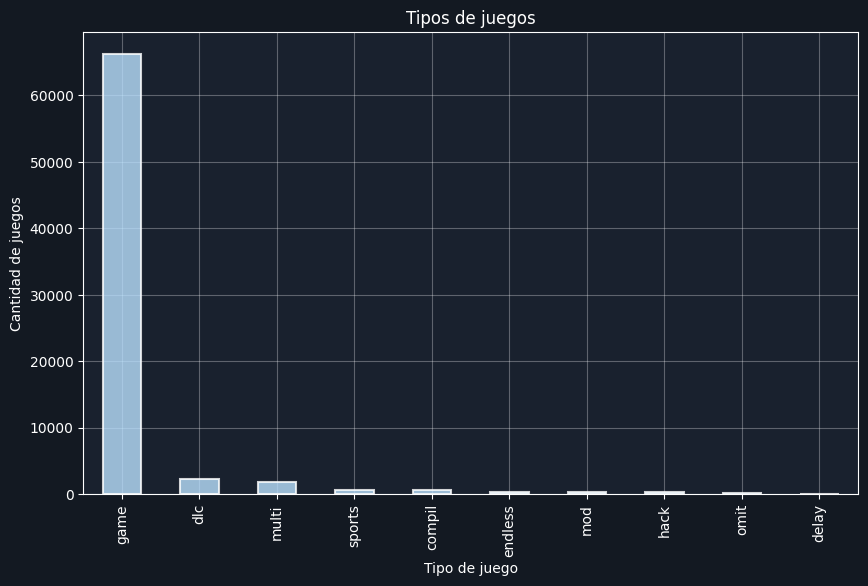

In [27]:
# Graficamos los tipos de juegos
fig, ax = plt.subplots(figsize=(10, 6))
data_clean['game_game_type'].value_counts().plot(kind='bar', color= "#BAE1FF", edgecolor='white',  linewidth=1.5, zorder=2, alpha=0.8)
plt.xlabel('Tipo de juego')
plt.ylabel('Cantidad de juegos')
fig.patch.set_facecolor("#131922")  # Fondo de la figura (exterior)
ax.set_facecolor("#19212E")         # Fondo del área del gráfico (interior)
plt.grid(zorder=1, alpha=0.3)
plt.title('Tipos de juegos')   

La mayoría es del tipo 'game' por lo cual no es concluyente si se ocupa esta categoría. Por último queda ver la distribución de juegos que tienen modalidades de solo player, cooperative y multiplayer. Para esto se va a crear una nueva variable usando los valores binarios que se tiene en las categorias, quedando por ejemplo:

<table>
    <tr><th>Código</th><th>Modos</th></tr>
    <tr><td>111</td><td>sp, co, mp</td></tr>
    <tr><td>100</td><td>sp</td></tr>
    <tr><td>101</td><td>sp, mp</td></tr>
</table>

Con esto para tener una distribución de los tipos de modalidades de juego posibles.

C:\Users\conid\AppData\Local\Temp\ipykernel_32284\41632697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['game_comp_lvl'] = data_clean[['game_comp_lvl_sp', 'game_comp_lvl_co', 'game_comp_lvl_mp']].apply(lambda x:''.join(x.astype(str)), axis=1)


Text(0.5, 1.0, 'Modalidades de los juegos')

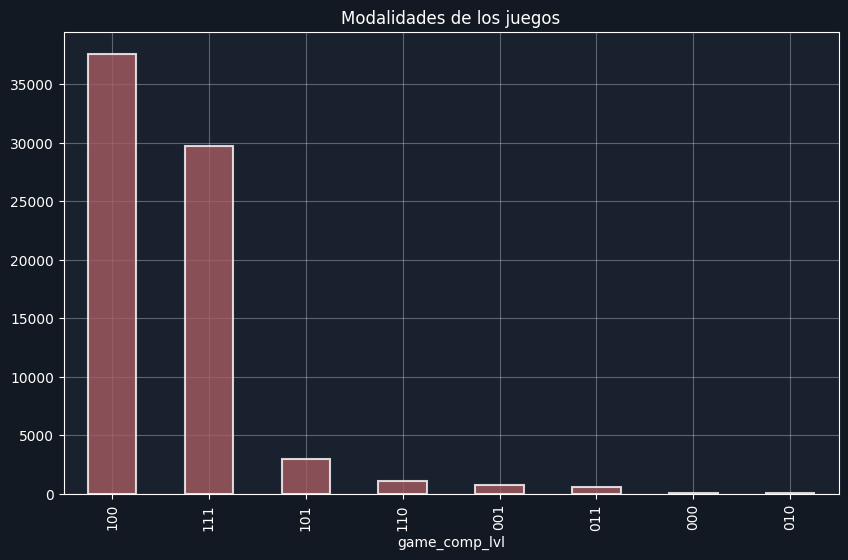

In [28]:
# Creamos nueva variable para ver modalidad de los juegos
data_clean['game_comp_lvl'] = data_clean[['game_comp_lvl_sp', 'game_comp_lvl_co', 'game_comp_lvl_mp']].apply(lambda x:''.join(x.astype(str)), axis=1)  

fig, ax = plt.subplots(figsize=(10, 6))
data_clean['game_comp_lvl'].value_counts().plot(kind='bar', edgecolor='white',  linewidth=1.5, zorder=2, alpha=0.8)
fig.patch.set_facecolor("#131922")  # Fondo de la figura (exterior)
ax.set_facecolor("#19212E")         # Fondo del área del gráfico (interior)
plt.grid(zorder=1, alpha=0.3)
plt.title('Modalidades de los juegos')
